# Setup & Data Loading

In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# add root to path
sys.path.append('..')
from src.data_loader import create_returns_matrix

# load config
with open('../config/params.yaml', 'r') as f:
    config = yaml.safe_load(f)

# load matrix using master file path from config
path = "../" + config['procurement_optimization']['data']['strategies_dir']
returns_matrix = create_returns_matrix(path)

# dictionary with the weights from your last execution
optimal_weights = {
    'Pernada_S_v201_WIN_3': 1.024706,
    'Pernada_S_v201_WIN_6': 0.879438,
    'RSIEst_Eng_v101_par2': 0.609617,
    'RSIEst_Eng_v101_par4': 0.400590,
    'Riv_T_v202_WDO_par3': 3.110903,
    'Riv_T_v202_WDO_par5': 3.010563,
    'Riv_T_v202_WIN_par1': 5.0,
    'Riv_T_v202_WIN_par2': 5.0,
    'Riv_T_v202_WIN_par3': 5.0,
    'Riv_T_v202_WIN_par4': 0.723901,
    'Riv_T_v202_WIN_par6': 0.240290
}

debug: processing path -> ../data/raw/procurement/spreadsheets/operacoes_intermediario_otimizado.csv
debug: file mode. parsing master sheet...
success: matrix created (18 strategies)


# Visualization

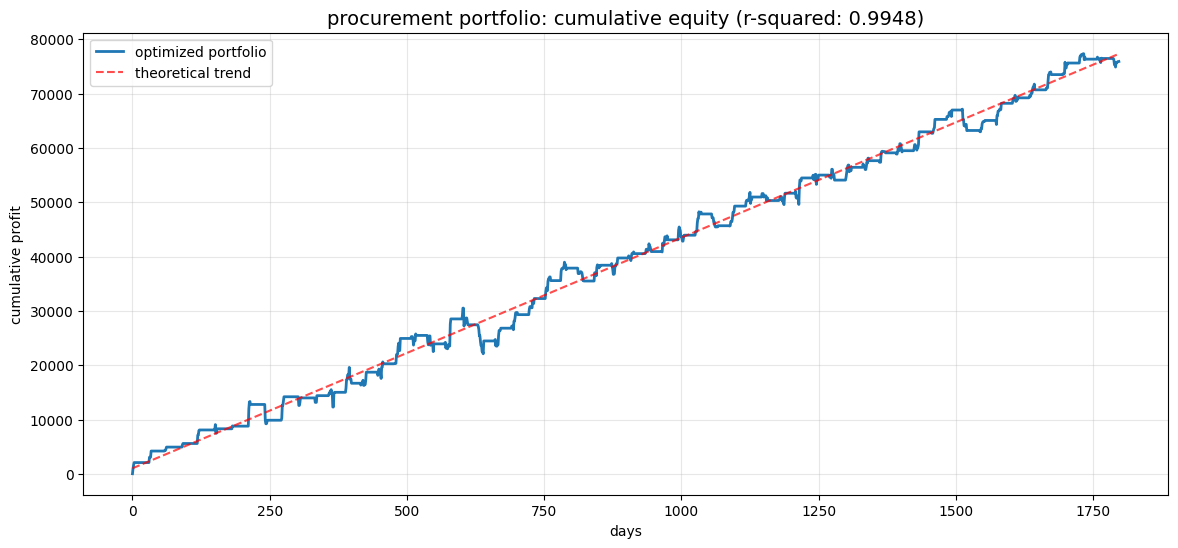

In [2]:
# calculate portfolio series
weights_vector = np.array([optimal_weights.get(col, 0) for col in returns_matrix.columns])
portfolio_pnl = (returns_matrix * weights_vector).sum(axis=1)
equity_curve = portfolio_pnl.cumsum()

# linear regression for trendline
x = np.arange(len(equity_curve))
y = equity_curve.values
slope, intercept = np.polyfit(x, y, 1)
trendline = slope * x + intercept

# plot
plt.figure(figsize=(14, 6))
plt.plot(y, label='optimized portfolio', color='#1f77b4', lw=2)
plt.plot(trendline, label='theoretical trend', linestyle='--', color='red', alpha=0.7)
plt.title(f'procurement portfolio: cumulative equity (r-squared: 0.9948)', fontsize=14)
plt.xlabel('days')
plt.ylabel('cumulative profit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
# convert dictionary to dataframe
df_weights = pd.DataFrame(list(optimal_weights.items()), columns=['strategy', 'weight'])
df_weights = df_weights.sort_values(by='weight', ascending=False).reset_index(drop=True)

# calculate relative importance (%)
total_b = df_weights['weight'].sum()
df_weights['share_pct'] = (df_weights['weight'] / total_b) * 100

# apply styling for notebook visualization
styled_df = df_weights.style.format({
    'weight': '{:.4f}',
    'share_pct': '{:.2f}%'
}).background_gradient(subset=['weight'], cmap='YlGn') \
  .set_caption("optimal strategy allocation (procurement mode)")

styled_df

NameError: name 'pd' is not defined

# Matrix correlation

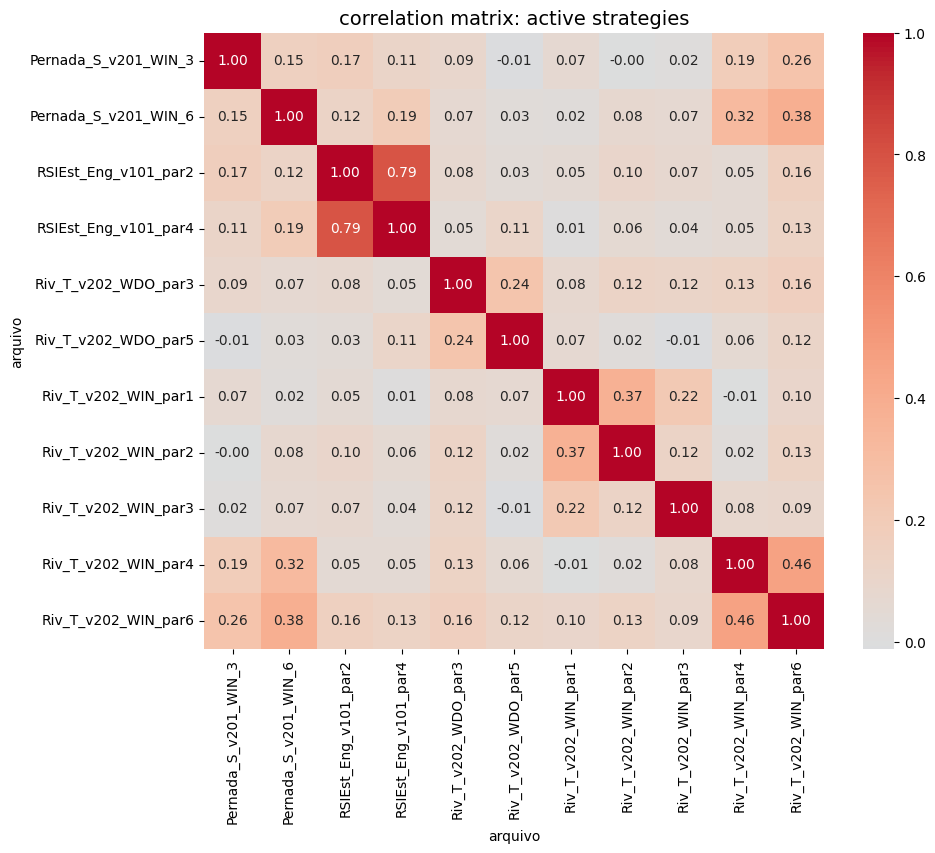

In [3]:
# filter active strategies only
active_cols = list(optimal_weights.keys())
corr_matrix = returns_matrix[active_cols].corr()

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('correlation matrix: active strategies', fontsize=14)
plt.show()

# Stability


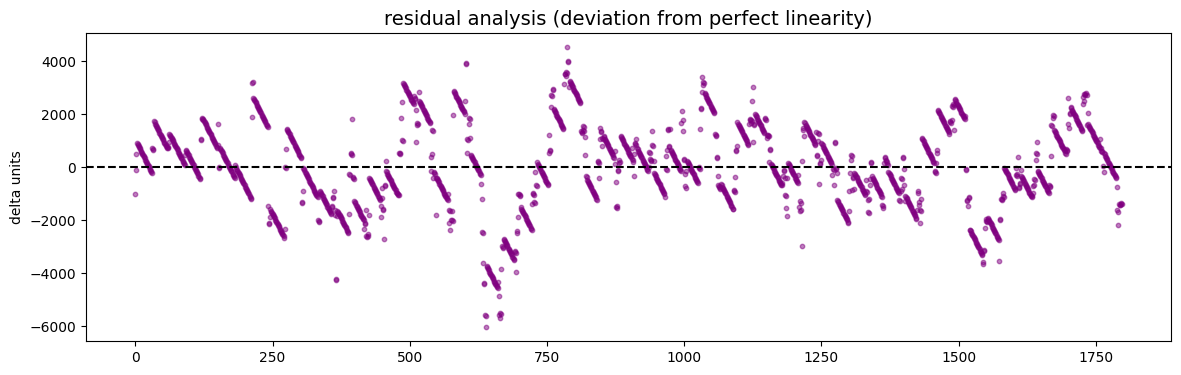

In [4]:
residuals = y - trendline

plt.figure(figsize=(14, 4))
plt.scatter(x, residuals, alpha=0.5, s=10, color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title('residual analysis (deviation from perfect linearity)', fontsize=14)
plt.ylabel('delta units')
plt.show()